Import dependencies

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
%matplotlib inline

Const

In [99]:
train_path = r'chest_Xray/train'
test_path = r'chest_Xray/test'
val_path = r'chest_Xray/val'

labels = ['NORMAL', 'PNEUMONIA']

IMG_SIZE=200

scale = 0.7

# try K=1 through K=15 and record testing accuracy
k_range = range(1, 16)
# Take time for timer
time1 = time.time()

Import images into array function

In [100]:
def get_training_data(data_dir, size):
    data = list()
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for image in os.listdir(path):
            if(image!=".DS_Store"):
                try:
                    image_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(image_arr, (size, size)) 
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(e)
    return np.array(data, dtype="object")

In [101]:
test = get_training_data(test_path, IMG_SIZE)
train = get_training_data(train_path, IMG_SIZE)
val = get_training_data(val_path, IMG_SIZE)

Balence datasets

In [102]:
def mix_datasets(array):
    # Pneumonie
    arr_1 = array[np.where(array[:,1] == 1)]
    # Normal
    arr_0 = array[np.where(array[:,1] == 0)]
    l_arr_1 = len(arr_1)
    l_arr_0 = len(arr_0)
    diff = 0

    if l_arr_0 > l_arr_1:
        diff = l_arr_0 - l_arr_1
        arr_0.resize((l_arr_0 - diff, arr_0.shape[1]))
        array = np.concatenate((l_arr_0, arr_1))
    else:
        diff = l_arr_1 - l_arr_0
        arr_1.resize((l_arr_1 - diff, arr_1.shape[1]))
        array = np.concatenate((arr_0, arr_1))
    return array


Scaling datsets

In [103]:
# # train_scaled = train
# test_scaled = test
# train_scaled = train[np.random.randint(train.shape[0], size=int(len(train)*scale)), :]
# # test_scaled = test[np.random.randint(test.shape[0], size=int(len(test)*scale)), :]

Preparing the data

In [104]:
def prepare_dataset(dataset):
    X_ = list() 
    y_ = list()
    for features, label in dataset:
        X_.append(features)
        y_.append(label)
    X_ = np.array(X_)
    X_ = X_.reshape(-1, IMG_SIZE * IMG_SIZE)
    y_ = np.array(y_)
    return X_, y_ 

In [105]:
x_train, label_train = prepare_dataset(mix_datasets(train))
x_test, label_test = prepare_dataset(mix_datasets(test))
x_val, label_val = prepare_dataset(mix_datasets(val))

Train test split

In [106]:
# Append train + test data in order to scale our datasets
X = np.concatenate((x_train, x_test))
X = np.concatenate((X, x_val))
Y = np.concatenate((label_train, label_test))
Y = np.concatenate((Y, label_val))

In [107]:
# test_size: what proportion of original data is used for test set
x_train, x_test, label_train, label_test = train_test_split( X, Y, test_size=0.30)

Transform / Normalize data

In [108]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_train)
# Apply transform to both the training set and the test set.
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Find Best numbers of neighbors

Text(0, 0.5, 'Testing Accuracy')

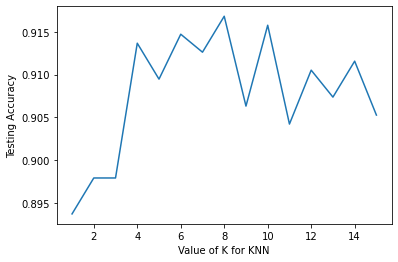

In [109]:
scores = []
# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, label_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(label_test, y_pred))
max = np.amax(scores) 
itemindex = np.where(scores==max)
neighbors_max = itemindex[0]+1

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

### Final model
train

In [110]:
KNN = KNeighborsClassifier(int(neighbors_max[0]))
KNN.fit(x_train, label_train)

# Print duration time
duration_time = time.time() - time1
if duration_time < 60 :  
    print("{} s".format(duration_time)) 
else : 
    print("{} min".format(duration_time/60))

1.5707315444946288 min


#### Predict

In [111]:
pred = KNN.predict(x_test)
# predicted_classes = np.argmax(pred, axis=0)
print(metrics.accuracy_score(pred, label_test))
report = classification_report(pred, label_test, target_names=labels)
print(report)   

0.9168421052631579
              precision    recall  f1-score   support

      NORMAL       0.89      0.95      0.92       451
   PNEUMONIA       0.95      0.89      0.92       499

    accuracy                           0.92       950
   macro avg       0.92      0.92      0.92       950
weighted avg       0.92      0.92      0.92       950



Confusion matrix

In [112]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Matrix confusion

Confusion matrix, without normalization
[[427  55]
 [ 24 444]]


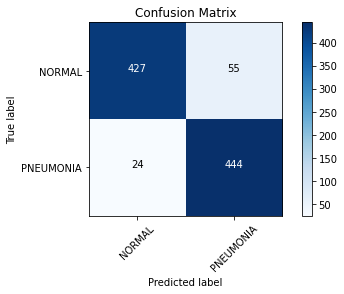

In [113]:
cm = confusion_matrix(y_true=label_test, y_pred=pred)
plot_confusion_matrix(cm=cm, classes=labels, title='Confusion Matrix')

In [114]:
score = KNN.score(x_test, label_test)

print(f'Test accuracy : {score:4.4f}')

Test accuracy : 0.9168


Duration time without PCA

In [115]:
import datetime
duration_time = time.time() - time1
print(datetime.timedelta(seconds=duration_time))

0:01:39.658456
